<a href="https://colab.research.google.com/github/sejuti-falgunii/Electroencephalography/blob/main/EEG_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!pip install mne
!pip install pyedflib

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt

###### this portion takes an EEG data file in .rec format, converts it to .edf format, loads it into MNE-Python, displays information about the data, and finally generates a plot to visualize a portion of the EEG signals.

Extracting EDF parameters from /content/drive/MyDrive/EEG/sleep-edf-database-1.0.0/sleep-edf-database-1.0.0/sc4112e0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8339999  =      0.000 ... 83399.990 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 7 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: 1989-05-02 15:20:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
 subject_info: <subject_info | his_id: X, sex: 1, last_name: X>
>


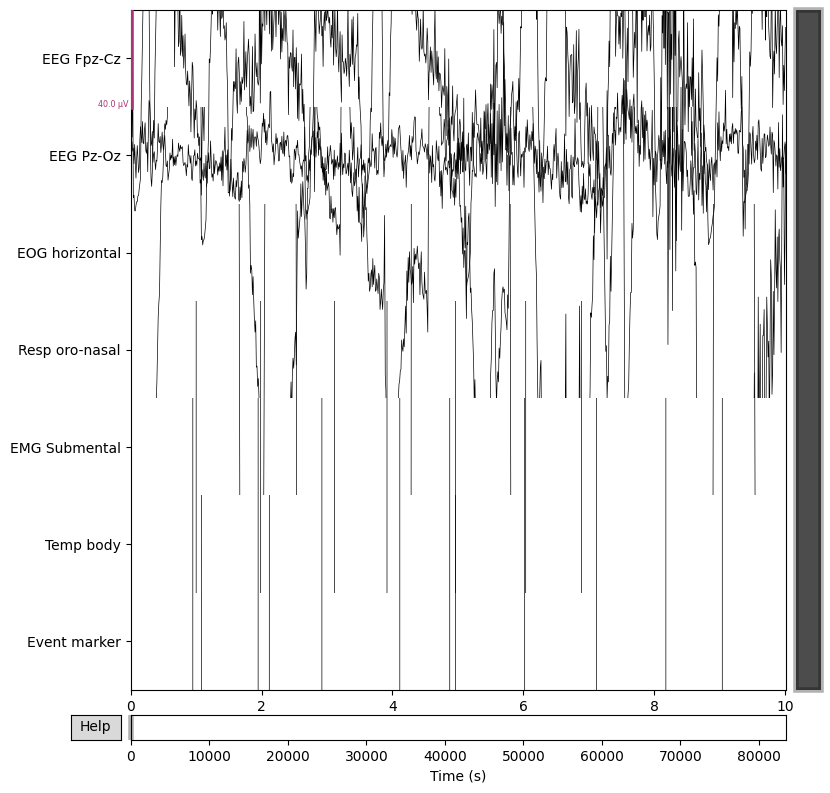

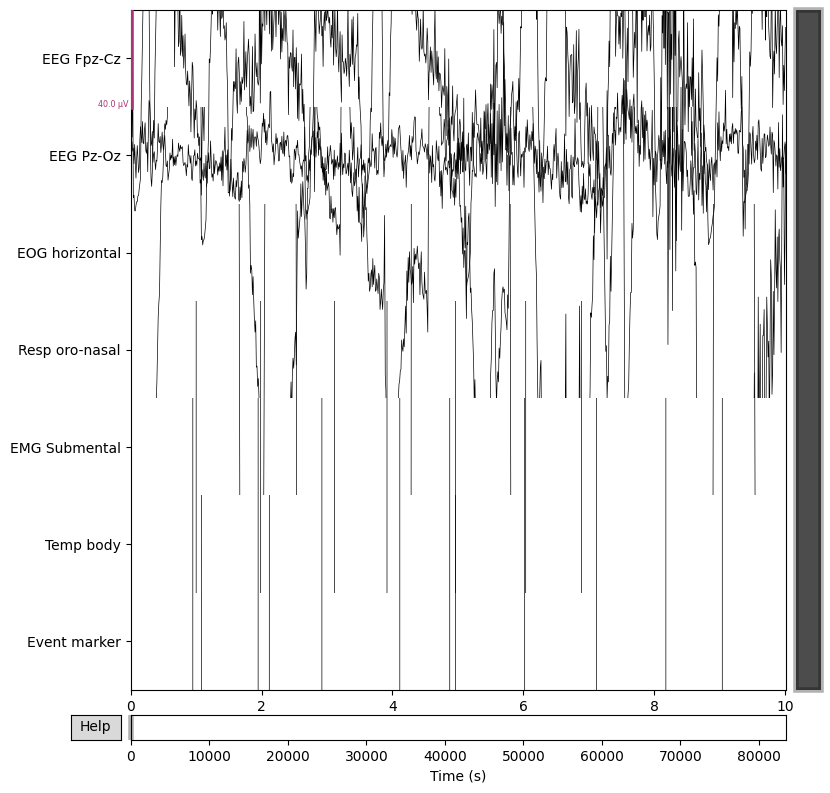

In [30]:
import shutil
import mne
# there are .rec and .edf files in the dataset
rec_path = "/content/drive/MyDrive/EEG/sleep-edf-database-1.0.0/sleep-edf-database-1.0.0/sc4112e0.rec"
edf_path = "/content/drive/MyDrive/EEG/sleep-edf-database-1.0.0/sleep-edf-database-1.0.0/sc4112e0.edf"

# Renaming .rec to .edf, .rec isn't recognized as a standard EEG format by the MNE-Python library
shutil.copy(rec_path, edf_path)
raw = mne.io.read_raw_edf(edf_path, preload=True)
print(raw.info)
raw.plot(duration=10, n_channels=20)

###### applying a bandpass filter to EEG data to remove unwanted noise and artifacts outside a specific frequency range, typically to retain the most relevant brainwave frequencies (e.g., 1–40 Hz) while eliminating low-frequency drift and high-frequency noise.

In [29]:
# Applying bandpass filter (1-40 Hz)
raw.filter(l_freq=1, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)



<RawEDF | sc4112e0.edf, 7 x 8340000 (83400.0 s), ~445.4 MiB, data loaded>

##### The portion prints the list of channel names in the EEG data to verify the channels. Then, it assigns specific types (EEG, EOG, EMG) to the channels using `raw.set_channel_types()` to ensure correct processing and analysis, like applying ICA to EEG channels while handling artifacts from EOG and EMG channels.

In [11]:
print(raw.info["ch_names"])

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG Submental', 'Temp body', 'Event marker']


In [12]:
raw.set_channel_types({
    "EEG Fpz-Cz": "eeg",
    "EEG Pz-Oz": "eeg",
    "EOG horizontal": "eog",
    "EMG Submental": "emg"
})


<RawEDF | sc4112e0.edf, 7 x 8340000 (83400.0 s), ~445.4 MiB, data loaded>

##### This portion raw.set_montage('standard_1020', on_missing='ignore') assigns a standard 10-20 electrode montage to the EEG data, ensuring accurate electrode positions for better visualization and analysis. The ica.plot_sources(raw) plots the time series of the ICA components instead of topographic maps, allowing you to inspect the raw signal of each component and identify artifacts or interesting features.

In [14]:
raw.set_montage('standard_1020', on_missing='ignore')

<RawEDF | sc4112e0.edf, 7 x 8340000 (83400.0 s), ~445.4 MiB, data loaded>

##### This portion visualizes the ICA components' time series to identify and exclude artifacts (like eye blinks or muscle movements). It then applies the exclusion to the raw EEG data, creating a cleaned version (raw_clean). Finally, it plots the cleaned data to check the effectiveness of the artifact removal.

Creating RawArray with float64 data, n_channels=4, n_times=8340000
    Range : 0 ... 8339999 =      0.000 ... 83399.990 secs
Ready.


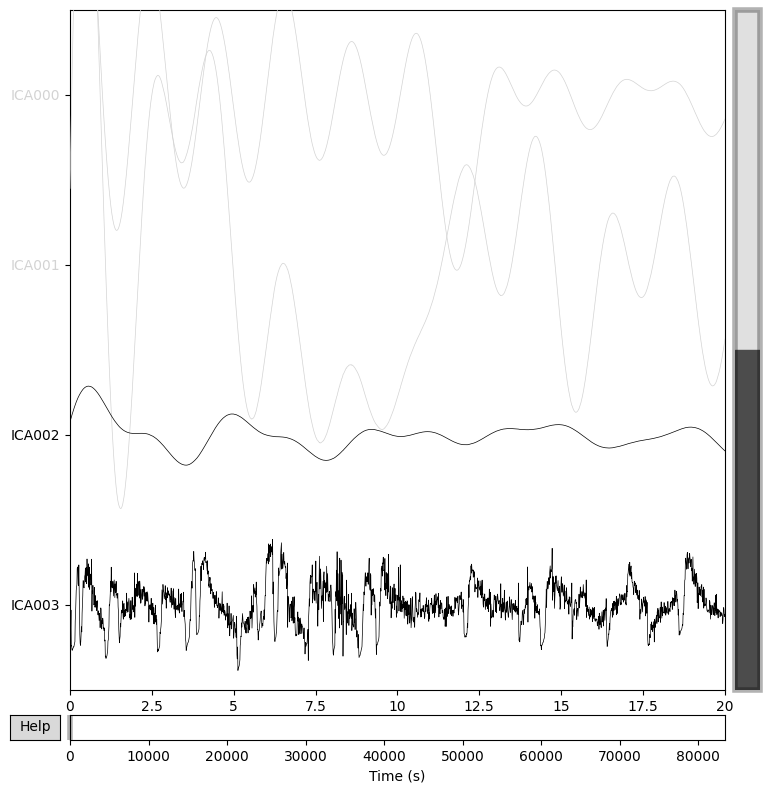

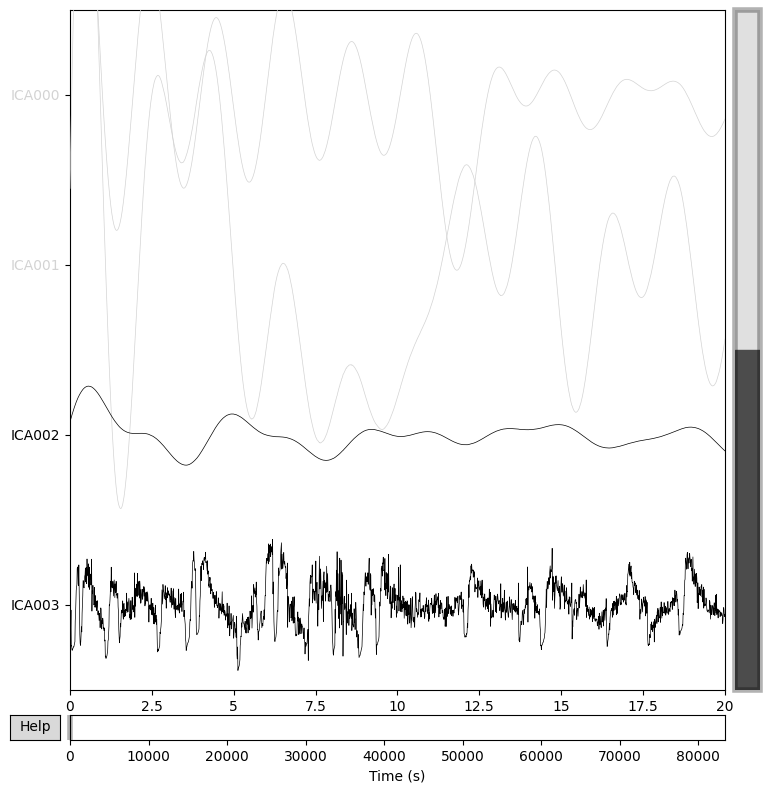

In [31]:
ica.plot_sources(raw)

Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 2 ICA components
    Projecting back using 5 PCA components


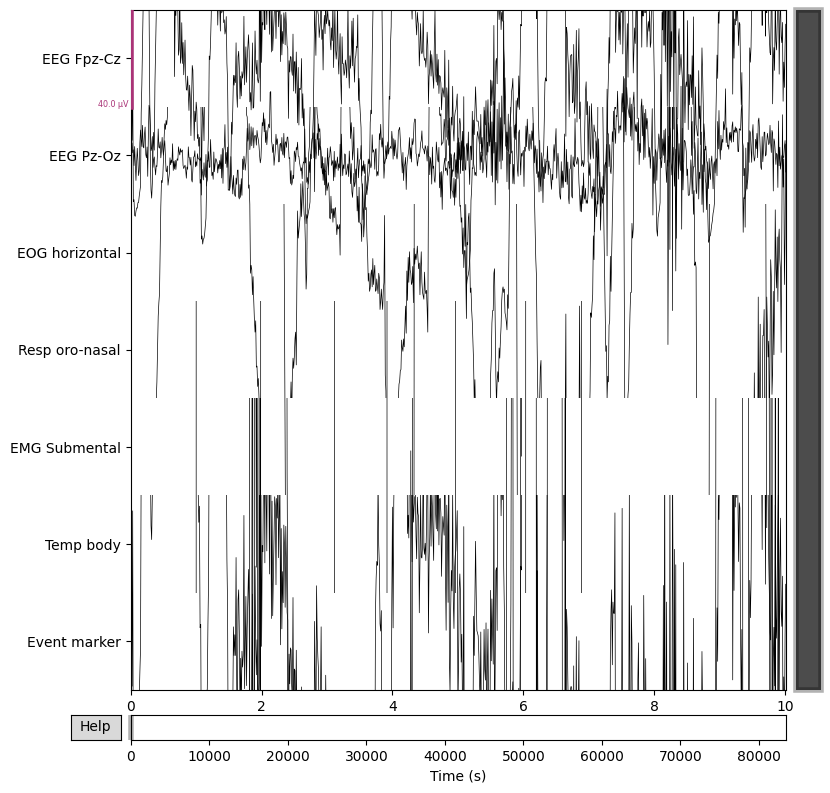

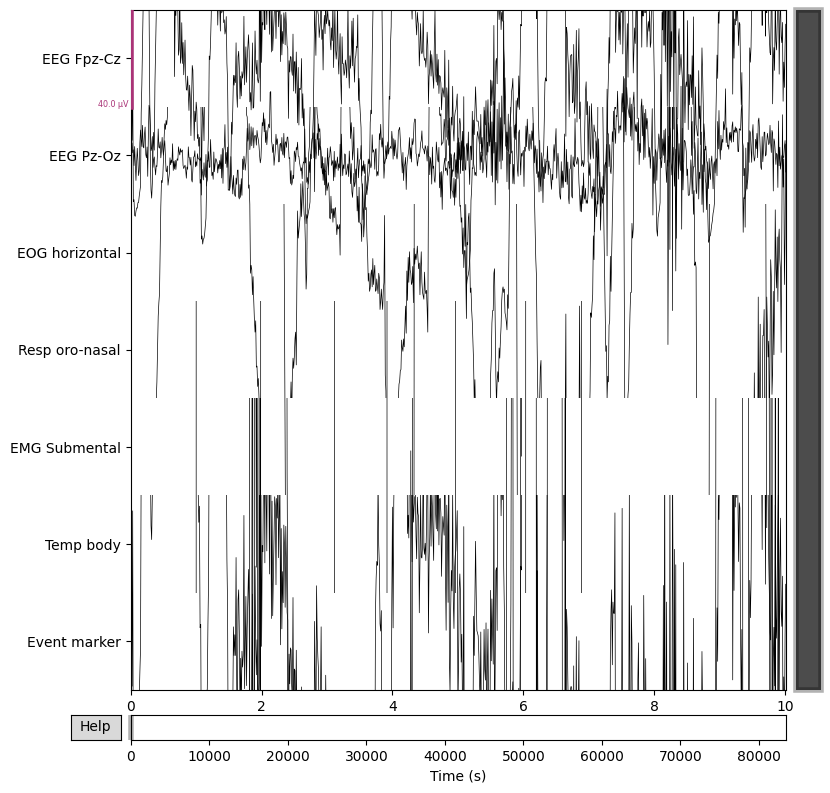

In [32]:
ica.exclude = [0, 1]  # this portion is excluded as an example
raw_clean = ica.apply(raw)
raw_clean.plot()

##### plotting the raw and the clean signal one by one

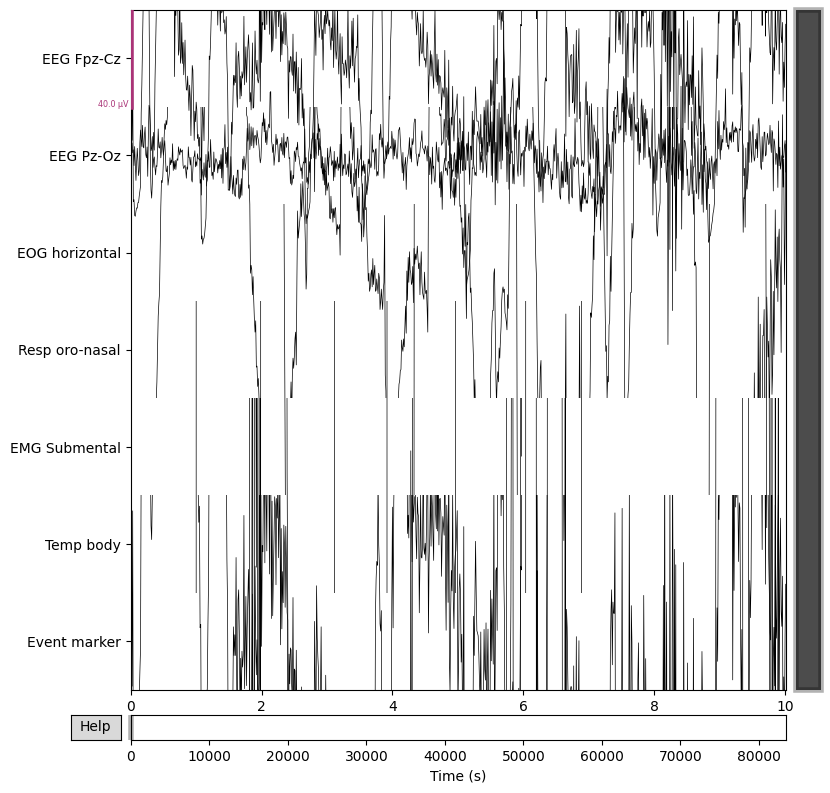

Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 2 ICA components
    Projecting back using 5 PCA components


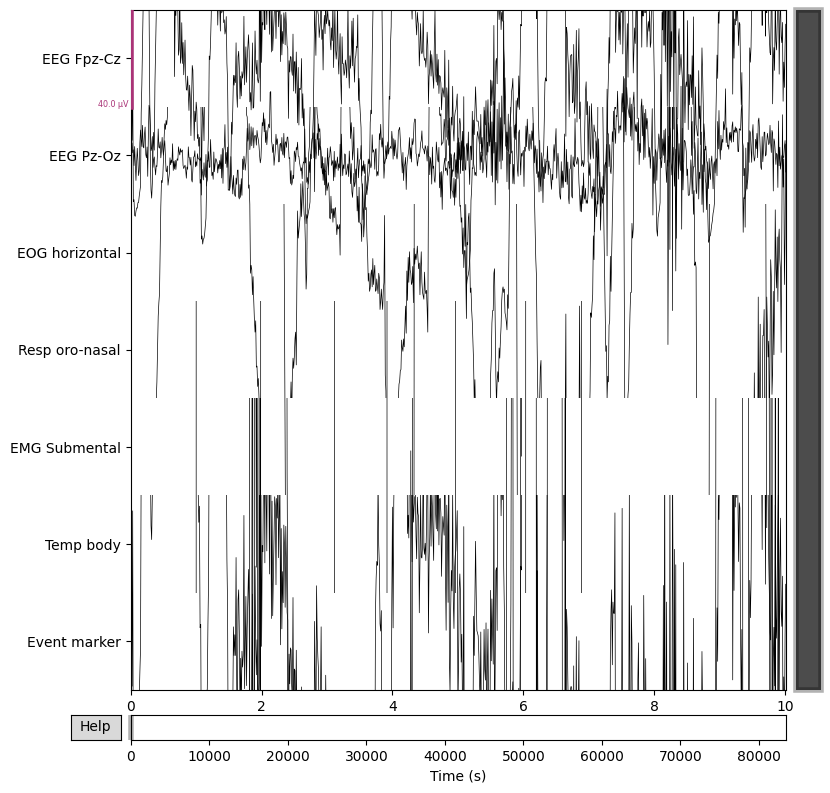

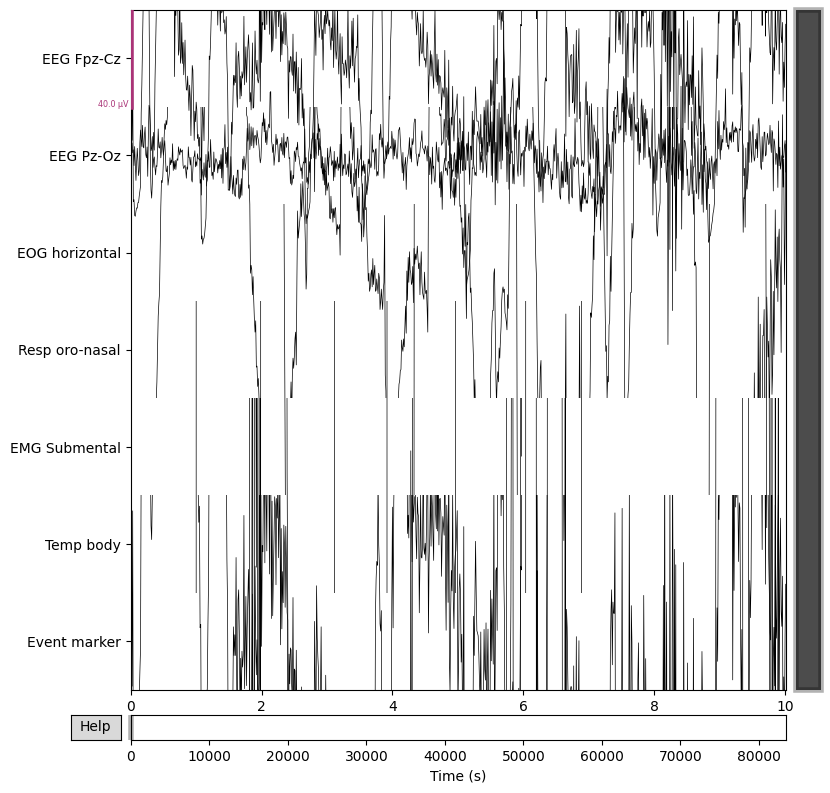

In [33]:
# the raw signal
raw.plot(duration=10, n_channels=10, title="Raw EEG Data")

# Applying ICA to remove artifacts fromt eh raw one
ica.apply(raw)

# the clean signal
raw.plot(duration=10, n_channels=10, title="Cleaned EEG Data")


##### saving and cleaning

In [34]:
cleaned_file = 'clean_eeg.fif'
raw.save(cleaned_file, overwrite=True)
print(f"Cleaned data saved to {cleaned_file}")

Writing /content/clean_eeg.fif
Closing /content/clean_eeg.fif
[done]
Cleaned data saved to clean_eeg.fif


##### The portion extracts epochs from EEG data based on specific events(examples). It defines events with timestamps and IDs, then creates epochs from the raw data, segmenting it into time windows around these events. The epochs are baseline-corrected, detrended, and visualized to study the brain's response to the stimuli, focusing on event-related brain potentials (ERPs) while removing noise and drift.

<Annotations | 0 segments>
Not setting metadata
3 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 71 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 3 events and 71 original time points ...


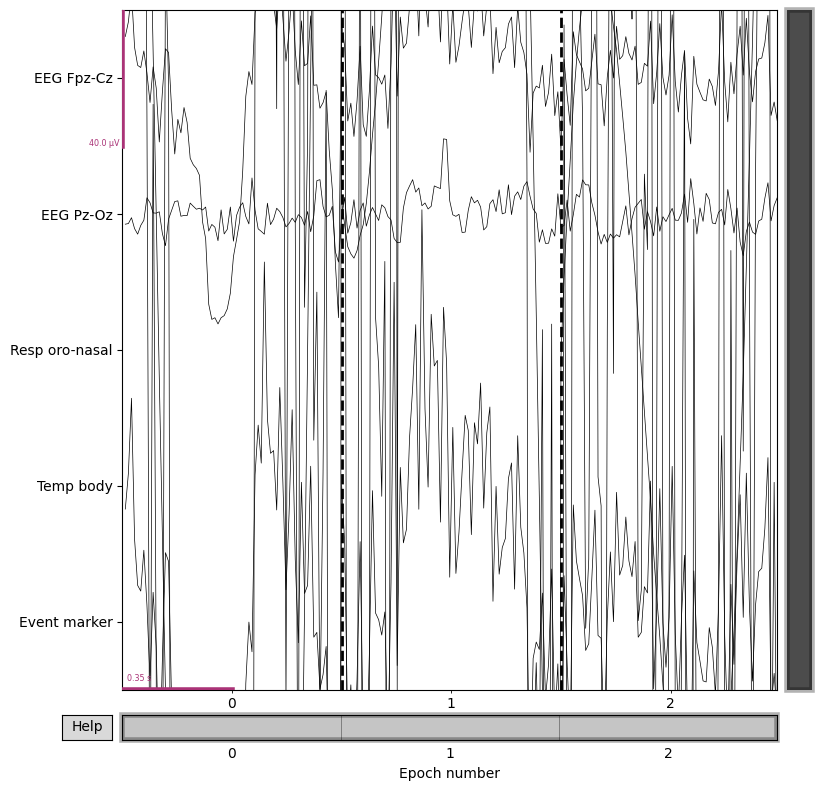

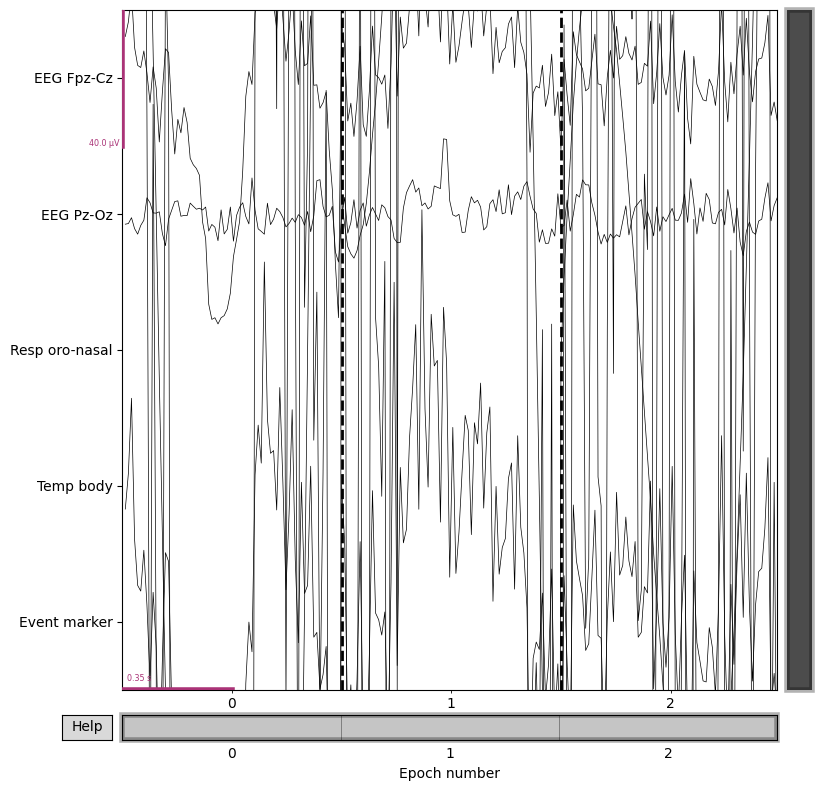

In [25]:
print(raw.annotations)
events = np.array([[100, 0, 1], [200, 0, 2], [300, 0, 3]])
event_id = {'stimulus_1': 1, 'stimulus_2': 2, 'stimulus_3': 3}

epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5, baseline=(None, 0), detrend=1)
epochs.plot()


##### Visualizing the epochs

Using data from preloaded Raw for 3 events and 71 original time points ...


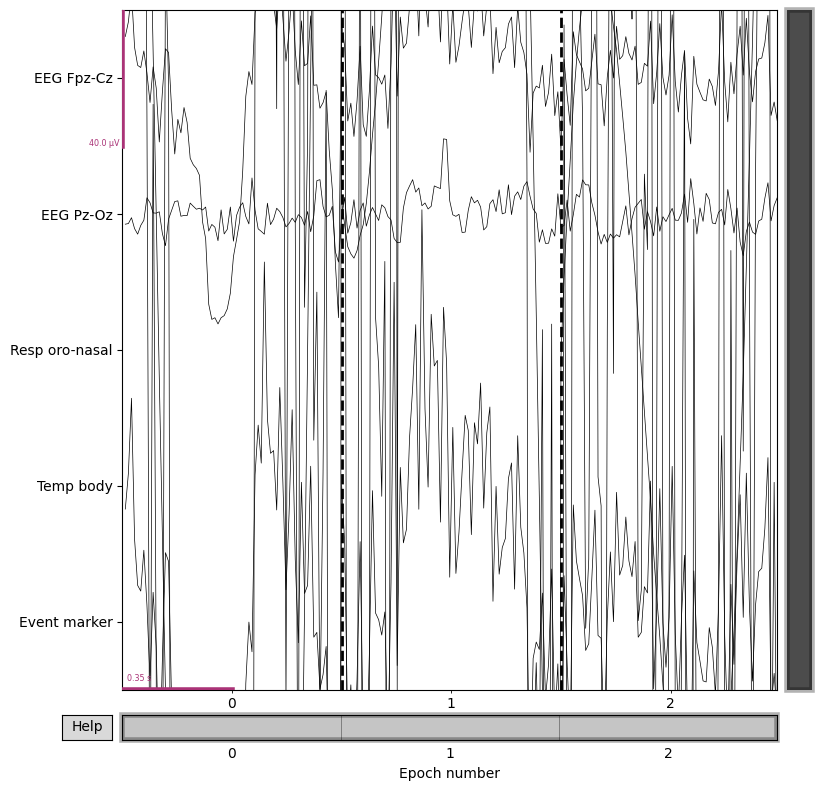

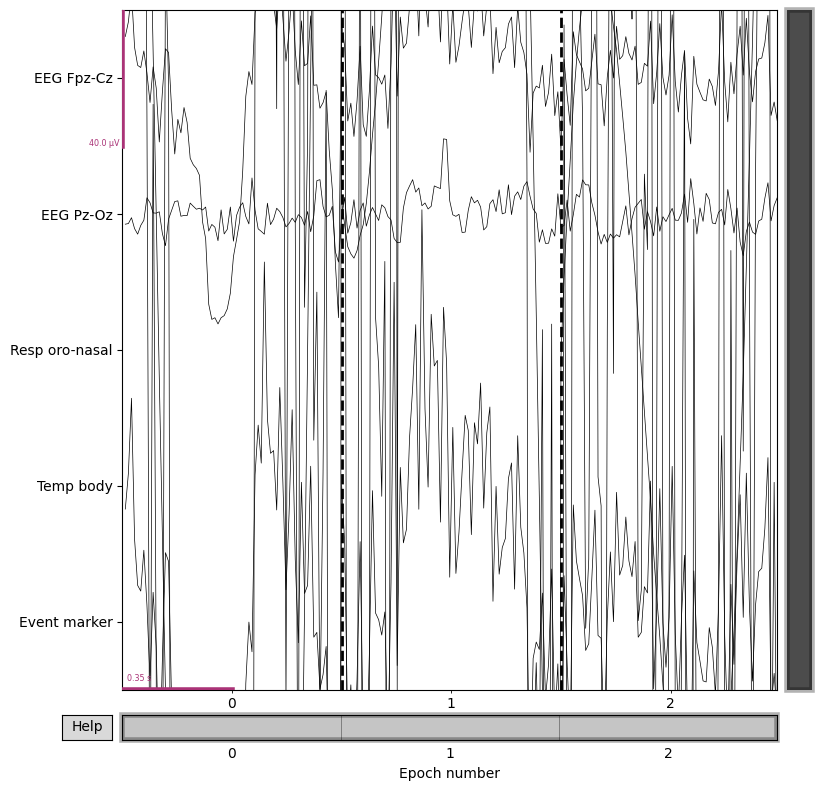

In [26]:
epochs.plot()

In [35]:
from google.colab import auth
auth.authenticate_user()

In [36]:
!git clone https://github.com/sejuti-falgunii/Electroencephalography.git

Cloning into 'Electroencephalography'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), done.


In [37]:
%cd Electroencephalography

/content/Electroencephalography


In [52]:
!mv "/content/drive/My Drive/Colab Notebooks/EEG_Preprocessing.ipynb" /content/Electroencephalography/

In [55]:
!git config --global user.email "sejutidhali@gmail.com"
!git config --global user.name "sejuti-falgunii"